### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

2023-02-01 10:20:12,303	INFO worker.py:1528 -- Started a local Ray instance.


#### Train the network

In [2]:
n = 10
#device = torch.device('mps')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 12 (seed=4255181447, Wed Feb  1 10:20:13 2023)


In [3]:
trainer.train(2000)

         iter : 1
    mean_eval : -116.23388671875
  median_eval : -99.99748229980469
pop_best_eval : 4.887506008148193
    best_eval : 4.887506008148193
   worst_eval : -394.8478698730469

         iter : 2
    mean_eval : -78.32095336914062
  median_eval : -74.15876007080078
pop_best_eval : -0.4543849229812622
    best_eval : 4.887506008148193
   worst_eval : -394.8478698730469

         iter : 3
    mean_eval : -86.84060668945312
  median_eval : -96.40287017822266
pop_best_eval : 0.14047212898731232
    best_eval : 4.887506008148193
   worst_eval : -394.8478698730469

         iter : 4
    mean_eval : -84.26004791259766
  median_eval : -18.201845169067383
pop_best_eval : 8.425572395324707
    best_eval : 8.425572395324707
   worst_eval : -538.7721557617188

         iter : 5
    mean_eval : -60.3730583190918
  median_eval : -67.64877319335938
pop_best_eval : 7.774716854095459
    best_eval : 8.425572395324707
   worst_eval : -538.7721557617188

         iter : 6
    mean_eval : -50.

In [4]:
network = trainer.get_trained_network()

#### Visualize trained network

In [5]:
organism = generate_organism(n, device)
graph = organism.toGraph()
visualizer = Visualizer()

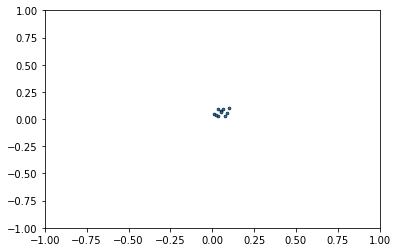

In [6]:
anim = visualizer.animate_organism(graph, network)
IPython.display.HTML(anim)